In [1]:
import warnings
warnings.filterwarnings("ignore", message="pkg_resources is deprecated")

In [2]:
print(f"*" * 100 + "\n**** Welcome to the Frozen Lake Toy Text Project" + ",a Reinforcement Learning" + "\n**** " + "implementation utilizing Q-Learning,a model-free based approach for solving games")
print(f"****" + " Experimented by:\n**** Bimal Thapa Magar")
print(f"*" * 100)

****************************************************************************************************
**** Welcome to the Frozen Lake Toy Text Project,a Reinforcement Learning
**** implementation utilizing Q-Learning,a model-free based approach for solving games
**** Experimented by:
**** Bimal Thapa Magar
****************************************************************************************************


In [3]:
from pyvirtualdisplay import Display
import numpy as np
import gymnasium as gym
import random
import tqdm
import imageio
import imageio_ffmpeg
from tqdm.notebook import trange

In [4]:
virtual_display =  Display(visible=False,size=(1400,900))
virtual_display.start()

In [5]:
env = gym.make('FrozenLake-v1',desc=None,map_name="4x4",is_slippery=False,render_mode="rgb_array")

In [6]:
print("___OBSERVATION SPACE______\n")
obs_space = env.observation_space
print("Observation Space:",obs_space.n)
print("Sample Observation:",obs_space.sample())

___OBSERVATION SPACE______

Observation Space: 16
Sample Observation: 12


In [7]:
print("____ACTION SPACE______\n")
act_space = env.action_space
print("Action Space Shape:",act_space.n)
print("Ation Space Sample:",act_space.sample())

____ACTION SPACE______

Action Space Shape: 4
Ation Space Sample: 3


In [8]:
state_space = obs_space.n
print(f"There are total of {state_space} possible states.")
print(f"There are total of {act_space.n} possible actions.")

There are total of 16 possible states.
There are total of 4 possible actions.


In [9]:
# Creating a Q-table of size (state_space,action_space) with initial value of 0 (initializing using numpy array with np.zeros)
def init_q_table(num_states,num_actions):
    q_table = np.zeros((num_states,num_actions))
    return q_table
print("Example Q table looks like this:\n",init_q_table(state_space,act_space.n))

Example Q table looks like this:
 [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [10]:
def epsilon_greedy_policy(state,epsilon,QTable):
    random_prob = random.uniform(0,1)
    if random_prob > epsilon: # ----> Exploitation
        # Take the highest value from the qtable in a given state
        action = np.argmax(Qtable[state])
    else: # -----> Exploration
        action = env.action_space.sample()
    return action

In [11]:
def greedy_policy(state,QTable):
    action = np.argmax(Qtable[state])
    return action

In [12]:
# HYPERPARAMETERS DEFINITION
## Training parameters
TRAIN_EPISODES = 1000  # Number of training episodes
LEARNING_RATE = 0.7

## Testing parameters
TEST_EPISODES = 100    # Number of testing episodes
SEED = 42

## Environment parameters
MAX_STEPS = 99 
MAX_EPSILON = 1
MIN_EPSILON = 0.05
DECAY_RATE = 0.0005
GAMMA = 0.95           # Discounting rate

In [13]:
def train(episodes,min_epsilon,max_epsilon,Qtable,decay_rate):
    for episode in trange(episodes):
        epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp( - decay_rate * episode)
        state = env.reset()[0]
        step = 0
        terminated = False

        for step in range(MAX_STEPS):
            # Choose action
            action = epsilon_greedy_policy(state,epsilon,Qtable)
            # Take action (a) and get new state (new_state) with reward
            new_state,reward,terminated,truncated,info = env.step(action)

            Qtable[state][action] =  Qtable[state][action] + LEARNING_RATE * (reward + GAMMA * np.max(Qtable[new_state]) -  Qtable[state][action])

            if terminated:
                break
            state = new_state
        # print(f"Episode: {episode + 1}; State: {state}\n")
    return Qtable
            

In [14]:
Qtable = init_q_table(state_space,act_space.n)

In [15]:
final_qtable = train(TRAIN_EPISODES,MIN_EPSILON,MAX_EPSILON,Qtable,DECAY_RATE)
final_qtable

  0%|          | 0/1000 [00:00<?, ?it/s]

array([[0.73509189, 0.77378094, 0.77378094, 0.73509189],
       [0.73509189, 0.        , 0.81450625, 0.77378094],
       [0.77378094, 0.857375  , 0.77378094, 0.81450625],
       [0.81450625, 0.        , 0.77378094, 0.77378094],
       [0.77378094, 0.81450625, 0.        , 0.73509189],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.9025    , 0.        , 0.81450625],
       [0.        , 0.        , 0.        , 0.        ],
       [0.81450625, 0.        , 0.857375  , 0.77378094],
       [0.81450625, 0.9025    , 0.9025    , 0.        ],
       [0.857375  , 0.95      , 0.        , 0.857375  ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.9025    , 0.95      , 0.857375  ],
       [0.9025    , 0.95      , 1.        , 0.9025    ],
       [0.        , 0.        , 0.        , 0.        ]])

In [16]:
def evaluate_agent(env,max_steps,test_episodes,Qtable,seed):
    episode_rewards = []
    for episode in range(test_episodes):
        if seed:
            state = env.reset(seed = seed)[0]
        else:
            state = env.reset()[0]
        step = 0
        terminated = False
        total_rewards_ep = 0

        for step in range(MAX_STEPS):
            action = np.argmax(Qtable[state])
            new_state,reward,terminated,truncated,info = env.step(action)
            total_rewards_ep += reward

            if terminated:
                break
            state = new_state
        episode_rewards.append(total_rewards_ep)
    mean_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)
    return mean_reward,std_reward
    

In [17]:
mean_reward,std_reward = evaluate_agent(env,MAX_STEPS,TEST_EPISODES,Qtable,SEED)
print(f"Mean reward : {mean_reward:.2f} +/- {std_reward:.2f}\n")

Mean reward : 1.00 +/- 0.00



In [23]:
def record_video(env,Qtable,out_directory,fps=1):
    images = []
    terminated = False
    state = env.reset(seed=SEED)[0]
    img = env.render()
    images.append(img)

    while not terminated:
        action = np.argmax(Qtable[state])
        state, reward,terminated,truncated,info = env.step(action)
        img = env.render()
        images.append(img)
    imageio.mimsave(out_directory,[np.array(img) for i,img in enumerate(images)],fps=fps,loop=0)

In [19]:
VIDEO_PATH = "final_game.gif"
VIDEO_FPS = 1

In [24]:
record_video(env,final_qtable,VIDEO_PATH,VIDEO_FPS)

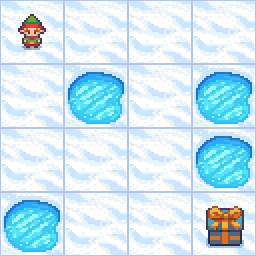

In [25]:
from IPython.display import Image
Image(VIDEO_PATH)